# Analysis of Assam 2022 Floods

In [1]:
import ee
import geemap

In [2]:
import pandas as pd

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [3]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


### All Functions

In [4]:
def addRatioBand(image):

    ratioBand = image.select('VV')\
                     .divide(image.select('VH'))\
                     .rename('VV/VH')
    
    return image.addBands(ratioBand)

def toDB(image):
    return ee.Image(image).log10().multiply(10.0)

def toNatural(image):
    return ee.Image(10.0).pow(image.select(0).divide(10.0))

##### Speckle Lee Filter

In [5]:
def RefinedLee(image):
  #image must be in natural units, i.e. not in dB
  # Set up 3x3 kernel
  
  
  weights3 = ee.List.repeat(ee.List.repeat(1,3),3)
  kernel3 = ee.Kernel.fixed(3,3, weights3, 1, 1, False)

  mean3 = image.reduceNeighborhood(ee.Reducer.mean(), kernel3)
  variance3 = image.reduceNeighborhood(ee.Reducer.variance(), kernel3)

  # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
  sample_weights = ee.List([[0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0], [0,1,0,1,0,1,0], [0,0,0,0,0,0,0], [0,1,0,1,0,1,0],[0,0,0,0,0,0,0]])

  sample_kernel = ee.Kernel.fixed(7,7, sample_weights, 3,3, False)

  # Calculate mean and variance for the sampled windows and store as 9 bands
  sample_mean = mean3.neighborhoodToBands(sample_kernel) 
  sample_var = variance3.neighborhoodToBands(sample_kernel)

  # Determine the 4 gradients for the sampled windows
  gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
  gradients = gradients.addBands(sample_mean.select(6).subtract(sample_mean.select(2)).abs())
  gradients = gradients.addBands(sample_mean.select(3).subtract(sample_mean.select(5)).abs())
  gradients = gradients.addBands(sample_mean.select(0).subtract(sample_mean.select(8)).abs())

  # And find the maximum gradient amongst gradient bands
  max_gradient = gradients.reduce(ee.Reducer.max())

  # Create a mask for band pixels that are the maximum gradient
  gradmask = gradients.eq(max_gradient)

  # duplicate gradmask bands: each gradient represents 2 directions
  gradmask = gradmask.addBands(gradmask)

  # Determine the 8 directions
  directions = sample_mean.select(1).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(7))).multiply(1)
  directions = directions.addBands(sample_mean.select(6).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(2))).multiply(2))
  directions = directions.addBands(sample_mean.select(3).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(5))).multiply(3))
  directions = directions.addBands(sample_mean.select(0).subtract(sample_mean.select(4)).gt(sample_mean.select(4).subtract(sample_mean.select(8))).multiply(4))
  # The next 4 are the not() of the previous 4
  directions = directions.addBands(directions.select(0).Not().multiply(5))
  directions = directions.addBands(directions.select(1).Not().multiply(6))
  directions = directions.addBands(directions.select(2).Not().multiply(7))
  directions = directions.addBands(directions.select(3).Not().multiply(8))

  # Mask all values that are not 1-8
  directions = directions.updateMask(gradmask)

  # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
  directions = directions.reduce(ee.Reducer.sum())  

  # pal = ['ffffff','ff0000','ffff00', '00ff00', '00ffff', '0000ff', 'ff00ff', '000000']
  #Map.addLayer(directions.reduce(ee.Reducer.sum()), {min:1, max:8, palette: pal}, 'Directions', false)

  sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

  # Calculate localNoiseVariance
  sigmaV = sample_stats.toArray().arraySort().arraySlice(0,0,5).arrayReduce(ee.Reducer.mean(), [0])

  # Set up the 7*7 kernels for directional statistics
  rect_weights = ee.List.repeat(ee.List.repeat(0,7),3).cat(ee.List.repeat(ee.List.repeat(1,7),4))

  diag_weights = ee.List([[1,0,0,0,0,0,0], [1,1,0,0,0,0,0], [1,1,1,0,0,0,0], 
    [1,1,1,1,0,0,0], [1,1,1,1,1,0,0], [1,1,1,1,1,1,0], [1,1,1,1,1,1,1]])

  rect_kernel = ee.Kernel.fixed(7,7, rect_weights, 3, 3, False)
  diag_kernel = ee.Kernel.fixed(7,7, diag_weights, 3, 3, False)

  # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
  dir_mean = image.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(directions.eq(1))
  dir_var = image.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(directions.eq(1))

  dir_mean = dir_mean.addBands(image.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(directions.eq(2)))
  dir_var = dir_var.addBands(image.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(directions.eq(2)))

  # and add the bands for rotated kernels
  for i in range(1,4):
    dir_mean = dir_mean.addBands(image.reduceNeighborhood(ee.Reducer.mean(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_var = dir_var.addBands(image.reduceNeighborhood(ee.Reducer.variance(), rect_kernel.rotate(i)).updateMask(directions.eq(2*i+1)))
    dir_mean = dir_mean.addBands(image.reduceNeighborhood(ee.Reducer.mean(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
    dir_var = dir_var.addBands(image.reduceNeighborhood(ee.Reducer.variance(), diag_kernel.rotate(i)).updateMask(directions.eq(2*i+2)))
  

  # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
  dir_mean = dir_mean.reduce(ee.Reducer.sum())
  dir_var = dir_var.reduce(ee.Reducer.sum())

  # A finally generate the filtered value
  varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(sigmaV.add(1.0))

  b = varX.divide(dir_var)

  result = dir_mean.add(b.multiply(image.subtract(dir_mean)))
  
  return(result.arrayFlatten([['sum']]))


### Loading all the datasets

In [6]:
#Loading JRC Global Surface Water Mapping Layer
gsw = ee.Image("JRC/GSW1_3/GlobalSurfaceWater")

#Loading WWF HydroSHEDS Void-Filled DEM, 3 Arc-Seconds
hydrosheds = ee.Image("WWF/HydroSHEDS/03VFDEM")

#Loading State Boundary
state_bound = ee.FeatureCollection('users/bakharia/India_State')\
    .filter(
        ee.Filter.inList('ST_NM', ['Assam']
        ))

#Loading District Boundaries
districts = ee.FeatureCollection('users/bakharia/Districts_India')

districts = districts.filter(ee.Filter.inList('ST_NM', ['Assam']))

###Loading dataset

dataset = ee.ImageCollection('COPERNICUS/S1_GRD')\
                .filter(ee.Filter.eq('instrumentMode', 'IW'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
                .filter(ee.Filter.eq('resolution_meters', 10))\
                .filter(ee.Filter.bounds(state_bound))\
                .select(['VV', 'VH'])

### Params (yearly and general)

In [7]:
before_Y22_start = '2022-04-01'
before_Y22_end = '2022-05-01'

after_Y22_start = '2022-05-02'
after_Y22_end = '2022-06-21'

diffThreshold = 1.25
slopeThrehold = 5
connectedPixelsThreshold = 8

### Operations for each year function

In [19]:
def extract_flood_data(dataset, gsw, hydrosheds, before_start, before_end, after_start, after_end, diffThreshold = 1.25, slopeThreshold = 5, connectedPixelsThreshold = 8, geometry= state_bound):

    before = dataset.filter(ee.Filter.date(before_start, before_end))\
                    .map(addRatioBand)\
                    .mosaic()\
                    .clip(geometry)
    
    after = dataset.filter(ee.Filter.date(after_start, after_end))\
                    .map(addRatioBand)\
                    .mosaic()\
                    .clip(geometry)

    before_filtered = toDB(RefinedLee(toNatural(before)))
    after_filtered = toDB(RefinedLee(toNatural(after)))

    differenced = after_filtered.divide(before_filtered)
    flood_init = differenced.gt(diffThreshold).rename('water').selfMask()

    permanent_water = gsw.select('seasonality')\
                         .gte(5)\
                         .clip(geometry)\
                         .unmask(0)\
                         .Not()
    flooded = flood_init.updateMask(permanent_water)

    terrain = ee.Algorithms.Terrain(hydrosheds)
    slope = terrain.select('slope')
    steepAreas = slope.gt(slopeThreshold)
    slopeMask = steepAreas.Not()
    flooded = flooded.updateMask(slopeMask)

    ''' 
    var connectedPixelThreshold = 8;
    var connections = flooded.connectedPixelCount(25)
    var disconnectedAreas = connections.lt(connectedPixelThreshold)
    var disconnectedAreasMask = disconnectedAreas.not()
    Map.addLayer(disconnectedAreas.selfMask(), {min:0, max:1, palette: ['yellow']}, 'Disconnected Areas', false)

    var flooded = flooded.updateMask(disconnectedAreasMask)
    '''

    connections = flooded.connectedPixelCount(25)
    disconnectedAreas = connections.lt(connectedPixelsThreshold)
    disconnectedAreasMask = disconnectedAreas.Not()
    flooded = flooded.updateMask(disconnectedAreasMask)

    totalArea = geometry.geometry()\
                        .area()\
                        .divide(1e4)
    print('Total Area:', totalArea.getInfo())
    
    stats = flooded.multiply(ee.Image.pixelArea()).reduceRegion(
            reducer = ee.Reducer.sum(),
            geometry = geometry.geometry(),
            scale = 30,
            maxPixels=  1e10,
            tileScale = 16
        )
    
    print('Flooded Area:', ee.Number(stats.get('water')).divide(1e4).getInfo())

    return before, after, before_filtered, after_filtered, flood_init, flooded, ee.Number(stats.get('water')).divide(1e4).getInfo(), totalArea.getInfo()
    
    

#extract_flood_data(dataset, gsw, hydrosheds, before_Y22_start, before_Y22_end, after_Y22_start, after_Y22_end)


In [30]:
def viz_Map(state_bound, districts, before, after, flooded, basemap = 'HYBRID'):

    Map = geemap.Map(basemap = basemap)
    Map.center_object(districts, 9)
    Map.addLayer(state_bound, {'color': 'grey'}, 'State Boundary')
    Map.addLayer(districts, {'color': 'blue'}, 'District', opacity= 0.5)
    Map.add_labels(districts, "DISTRICT", font_size="12pt", font_color="white", font_family="arial", font_weight="bold")
    Map.addLayer(before, {'min': -25, 'max': 0}, 'Before', False)
    Map.addLayer(after, {'min': -25, 'max': 0}, 'After', False)
    Map.addLayer(flooded, {'min': 0, 'max': 1, 'palette':['red']}, 'Flooded Area')

    return Map


In [10]:
#before, after, before_filtered, after_filtered, flood_init, flooded = extract_flood_data(dataset, gsw, hydrosheds, before_Y22_start, before_Y22_end, after_Y22_start, after_Y22_end)

In [11]:
# Map = geemap.Map(basemap = 'HYBRID')
# # url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
# # Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
# Map.center_object(state_bound, 8)
# Map.addLayer(state_bound, {'color': 'grey'}, 'State Boundary')
# Map.addLayer(districts, {'color': 'blue'}, 'District', opacity= 0.5)
# Map.addLayer(before, {'min': -25, 'max': 0}, 'Before', False)
# Map.addLayer(after, {'min': -25, 'max': 0}, 'After', False)
# Map.addLayer(flood_init, {'min': 0, 'max': 1, 'palette':['orange']}, 'Initial Flood Area', False)
# Map.addLayer(flooded, {'min': 0, 'max': 1, 'palette':['red']}, 'Flooded Area')
# Map
#districts.geometry().intersects(flooded.geometry())
#districts.geometry().intersects(flooded.geometry())
# ee.Image.pixelArea()

# print(flooded.pixelArea().select('area'))

In [12]:
i = 0
all_districts = list()
features = districts.getInfo()['features']

while True:
    try:
        all_districts.append(features[i]['properties']['DISTRICT'])
        i += 1
    except IndexError:
        break

print(", ".join(all_districts))

Baksa, Barpeta, Bongaigaon, Cachar, Chirang, Darrang, Dhemaji, Dhubri, Dibrugarh, Goalpara, Golaghat, Hailakandi, Nagaon, Sivasagar, Sonitpur, Tinsukia, Udalguri, Jorhat, Nalbari, Dima Hasao, Kamrup, Kamrup Metropolitan, Karbi Anglong, Karimganj, Kokrajhar, Lakhimpur, Marigaon


In [13]:
districts.filter(ee.Filter.inList('DISTRICT', ['Baksa'])).getInfo()

{'type': 'FeatureCollection',
 'columns': {'DISTRICT': 'String',
  'DT_CEN_CD': 'Integer',
  'ST_CEN_CD': 'Integer',
  'ST_NM': 'String',
  'censuscode': 'Long',
  'system:index': 'String'},
 'version': 1627362306321059,
 'id': 'users/bakharia/Districts_India',
 'properties': {'system:asset_size': 5077925},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[90.82025914676996, 26.56814454532645],
      [90.82166818983801, 26.56374339423353],
      [90.82410289252267, 26.560033412245076],
      [90.83203112568647, 26.55620756937136],
      [90.83155400456448, 26.540654163486042],
      [90.83308348602749, 26.54086820749861],
      [90.83343578067063, 26.540007662432718],
      [90.8340109547399, 26.53861194127363],
      [90.84559130520432, 26.535842838138876],
      [90.85053641942993, 26.5334839147386],
      [90.85661864420945, 26.53388528180789],
      [90.85508020784805, 26.52536835157752],
      [90.85411263463963, 26.523210228573],
      [90

In [42]:
map_list = []
total_area = []
flooded_area = []

for d in all_districts:
    print(f"####################################\n\t\t{d}\n####################################")

    district_d = districts.filter(ee.Filter.inList('DISTRICT', [d]))

    before, after, before_filtered, after_filtered, _, flooded, flood_area, area = extract_flood_data(dataset, gsw, hydrosheds, before_Y22_start, before_Y22_end, after_Y22_start, after_Y22_end, geometry= district_d)   

    total_area.append(area)
    flooded_area.append(flood_area)

    map_list.append(
        viz_Map(state_bound.filterBounds(district_d), district_d, before, after, flooded, basemap= "Stamen.Watercolor")
        )


####################################
		Baksa
####################################
Total Area: 237516.30457075697
Flooded Area: 51000.8384237793
####################################
		Barpeta
####################################
Total Area: 231489.9211341971
Flooded Area: 32089.053249603272
####################################
		Bongaigaon
####################################
Total Area: 105429.07326422702
Flooded Area: 10778.205682339705
####################################
		Cachar
####################################
Total Area: 379237.6577749291
Flooded Area: 37839.72043192285
####################################
		Chirang
####################################
Total Area: 173374.86931407594
Flooded Area: 11095.174799127197
####################################
		Darrang
####################################
Total Area: 161505.38082729574
Flooded Area: 35518.22332905274
####################################
		Dhemaji
####################################
Total Area: 261058.93692262212
Flo

In [41]:
map_list[-1]

Map(bottom=111793.2001953125, center=[25.9516235763293, 89.9717103224248], controls=(WidgetControl(options=['p…

In [47]:
map_districts = {}

for i in range(len(all_districts)):

        map_districts[all_districts[i]] = {
            'map': map_list[i],
            'total area': total_area[i],
            'flooded area': flooded_area[i]
        }
        

In [48]:
import pandas as pd

df = pd.DataFrame.from_dict(map_districts).T

df['per cent flooded'] = [(x[2]/x[1])*1e2 for x in df.values]

df

,map,total area,flooded area,per cent flooded
Baksa,"Map(center=[26.665013142994415, 91.34654683939...",237516.304571,51000.838424,21.472563
Barpeta,"Map(center=[26.34011040453365, 91.010703440209...",231489.921134,32089.05325,13.861966
Bongaigaon,"Map(center=[26.365195742429723, 90.62471430027...",105429.073264,10778.205682,10.223182
Cachar,"Map(center=[24.811073878916023, 92.85655968661...",379237.657775,37839.720432,9.977838
Chirang,"Map(center=[26.642965517093373, 90.61625597965...",173374.869314,11095.174799,6.399529
Darrang,"Map(center=[26.44924618560787, 92.037218555218...",161505.380827,35518.223329,21.991975
Dhemaji,"Map(center=[27.57793968636487, 94.777055032718...",261058.936923,20593.881533,7.888595
Dhubri,"Map(center=[26.067251259221937, 90.02212485617...",230152.159143,26302.728482,11.428408
Dibrugarh,"Map(center=[27.3664178499991, 95.0561633053075...",340116.017923,17596.737656,5.173746
Goalpara,"Map(center=[26.055612852916205, 90.60561085058...",201489.456805,16320.035484,8.099697


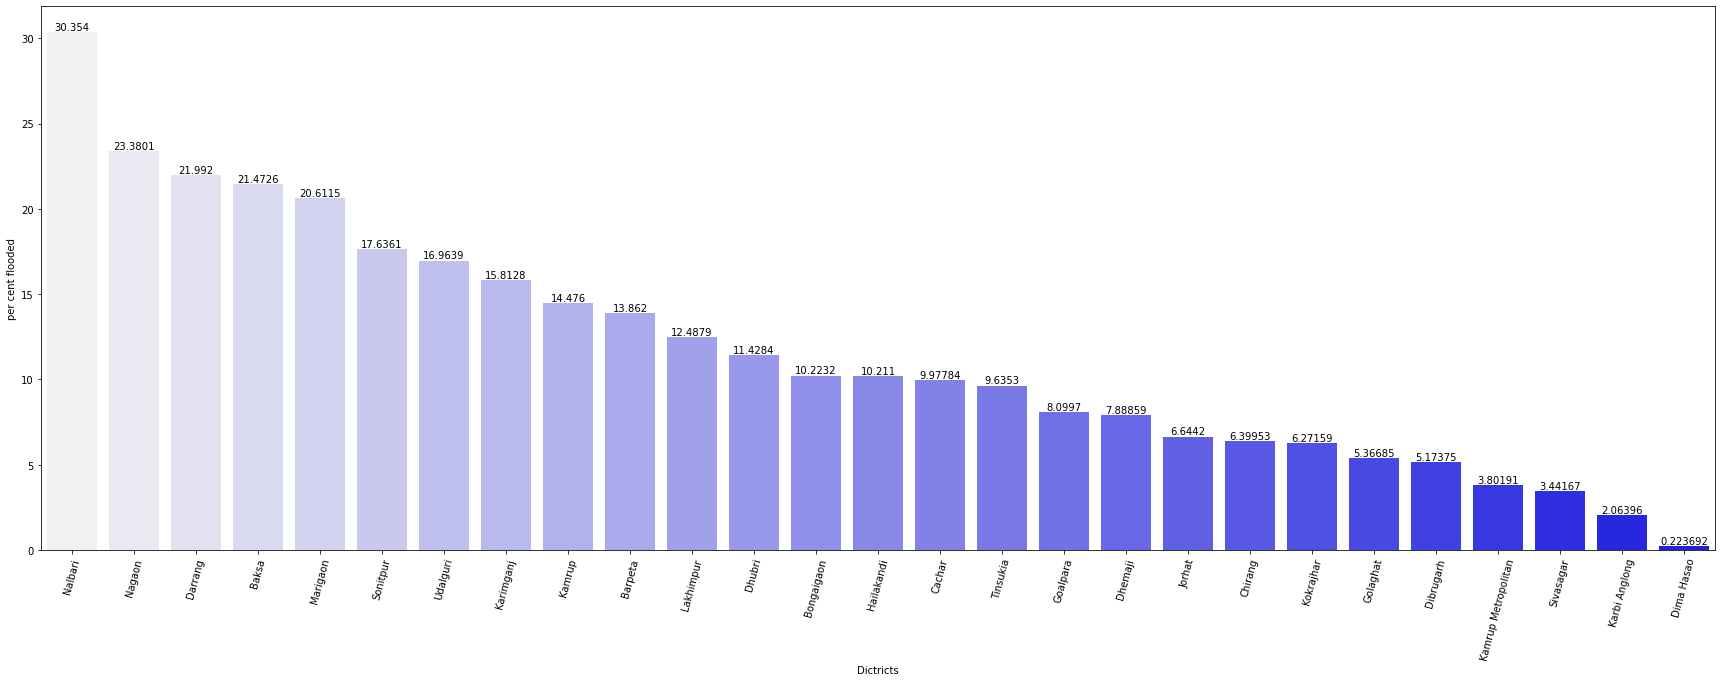

Nalbari                26
Nagaon                 25
Darrang                24
Baksa                  23
Marigaon               22
Sonitpur               21
Udalguri               20
Karimganj              19
Kamrup                 18
Barpeta                17
Lakhimpur              16
Dhubri                 15
Bongaigaon             14
Hailakandi             13
Cachar                 12
Tinsukia               11
Goalpara               10
Dhemaji                 9
Jorhat                  8
Chirang                 7
Kokrajhar               6
Golaghat                5
Dibrugarh               4
Kamrup Metropolitan     3
Sivasagar               2
Karbi Anglong           1
Dima Hasao              0
Name: per cent flooded, dtype: int64

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = df.sort_values(by = ['per cent flooded'], ascending= False)

pal = sns.color_palette("light:b", len(df))
rank = df['per cent flooded'].sort_values(ascending=False).argsort()



plt.figure(figsize=(30,10))
ax = sns.barplot(data = df, x = df.index, y = 'per cent flooded', palette=np.array(pal[::-1])[rank], ci = "sd")
ax.bar_label(ax.containers[0])
plt.xlabel('Dictricts')
plt.xticks(rotation = 75)
plt.show()

rank

In [111]:
#df.loc['Nalbari', 'map'].to_html()

for i in range(len(df.values)):
    #Map.to_html(outfile=html_file, title='My Map', width='100%', height='880px')
    df.iloc[i, 0].to_html(outfile = f'Maps//{df.index[i]}.html', title = f'{df.index[i]}', width = '100%', height = '880px')


In [112]:
df.to_csv('final_data.csv')

### Year 2020

In [ ]:
# before, after, before_filtered, after_filtered, flood_init, flooded = extract_flood_data(dataset, gsw, hydrosheds, '2020-04-01', '2020-05-01', '2020-05-02', '2020-10-01')

In [ ]:
# Map = geemap.Map(basemap = 'HYBRID')
# # url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
# # Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
# Map.center_object(state_bound, 7)
# Map.addLayer(state_bound, {'color': 'grey'}, 'State Boundary')
# Map.addLayer(districts, {'color': 'blue'}, 'District', opacity= 0.5)
# Map.addLayer(before, {'min': -25, 'max': 0}, 'Before', False)
# Map.addLayer(after, {'min': -25, 'max': 0}, 'After', False)
# Map.addLayer(flood_init, {'min': 0, 'max': 1, 'palette':['orange']}, 'Initial Flood Area', False)
# Map.addLayer(flooded, {'min': 0, 'max': 1, 'palette':['red']}, 'Flooded Area')
# Map

Map(center=[26.357526449660313, 92.81738631718238], controls=(WidgetControl(options=['position', 'transparent_…